# la distillation des connaissances


Dans les guide précédents, nous avons appris comment fonctionne BERT et nous avons également examiné différentes variantes de BERT. Nous avons appris que nous n'avons pas à former le BERT à partir de zéro ; au lieu de cela, nous pouvons affiner le modèle BERT pré-entraîné sur les tâches en aval. Cependant, l'un des défis liés à l'utilisation du modèle BERT pré-entraîné est qu'il est coûteux en termes de calcul et qu'il est très difficile d'exécuter le modèle avec des ressources limitées. Le modèle BERT pré-entraîné a un grand nombre de paramètres et également un temps d'inférence élevé, ce qui rend son utilisation plus difficile sur des appareils périphériques tels que les téléphones mobiles.

Pour atténuer ce problème, nous transférons les connaissances d'un grand BERT pré-formé à un petit BERT en utilisant la distillation des connaissances. Dans ce guide, nous allons découvrir plusieurs variantes du modèle BERT basées sur la distillation des connaissances.

Nous commencerons le guide en comprenant ce qu'est la distillation des connaissances et comment elle fonctionne en détail. Ensuite, nous découvrirons DistilBERT. Avec DistilBERT, nous verrons comment transférer des connaissances d'un grand BERT pré-formé vers un petit BERT en utilisant la distillation des connaissances en détail.

À l'avenir, nous en apprendrons davantage sur TinyBERT. Nous comprendrons ce qu'est TinyBERT et comment il acquiert les connaissances d'un grand BERT pré-formé en utilisant la distillation des connaissances. Nous examinerons également les différentes méthodes d'augmentation de données utilisées dans TinyBERT.

À la fin du guide, nous apprendrons comment transférer les connaissances d'un grand BERT pré-formé vers un simple réseau de neurones.

Dans ce guide, nous aborderons les sujets suivants :

* Présentation de la distillation des connaissances
* DistilBERT – la version distillée de BERT
* Présentation de TinyBERT
* Transfert de connaissances du BERT aux réseaux de neurones

## Présentation de la distillation des connaissances

La distillation des connaissances est une technique de compression de modèle dans laquelle un petit modèle est entraîné pour reproduire le comportement d'un grand modèle pré-entraîné. Il est également appelé apprentissage enseignant-élève, où le grand modèle pré-formé est l'enseignant et le petit modèle est l'élève. Comprenons comment fonctionne la distillation des connaissances avec un exemple.

Supposons que nous ayons pré-entraîné un grand modèle pour prédire le mot suivant dans une phrase. Nous appelons ce grand modèle pré-formé un réseau d'enseignants. Si nous alimentons une phrase et laissons le réseau prédire le mot suivant dans la phrase, alors il renverra la distribution de probabilité de tous les mots du vocabulaire étant le mot suivant, comme le montre la figure suivante. Notez que pour plus de simplicité et une meilleure compréhension, nous supposerons que nous n'avons que cinq mots dans notre vocabulaire :

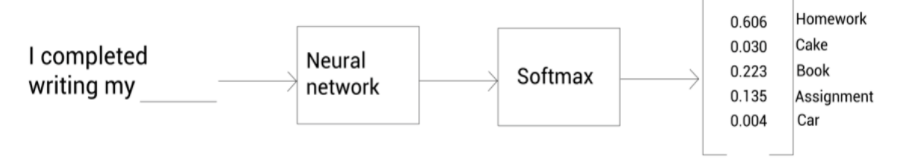

A partir de la figure précédente, nous pouvons observer la distribution de probabilité renvoyée par le réseau. Cette distribution de probabilité est essentiellement obtenue en appliquant la fonction softmax dans la couche de sortie et nous sélectionnons le mot qui a une forte probabilité d'être le mot suivant dans la phrase. Étant donné que le mot homework a une forte probabilité, nous sélectionnons le mot suivant dans la phrase comme homework.

Outre la sélection du mot à forte probabilité, pouvons-nous extraire d'autres informations utiles de la distribution de probabilité renvoyée par notre réseau ? Oui! A partir de la figure suivante, nous pouvons observer qu'en dehors du mot qui a la probabilité la plus élevée, il y a certains mots qui ont une probabilité élevée par rapport à d'autres mots. C'est-à-dire que, comme nous pouvons le voir, les mots Book et Assignment ont une probabilité légèrement plus élevée que d'autres mots tels que Cake et Car, comme le montre la figure suivante :

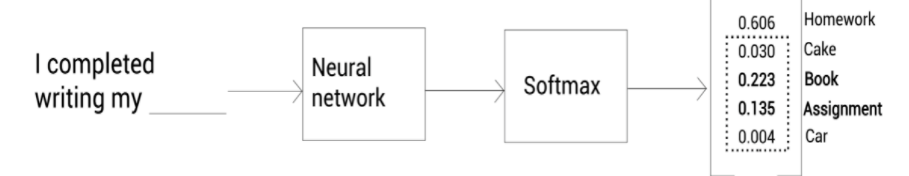

Cela indique qu'à part le mot homeworck, les mots book et homework sont plus pertinents pour la phrase donnée que des mots comme cake et car. C'est ce qu'on appelle la connaissance obscure. Au cours de la distillation des connaissances, nous voulons que notre réseau d'étudiants apprenne cette sombre connaissance de l'enseignant.

D'accord, mais généralement, tout bon modèle renverra une probabilité élevée proche de 1 pour la classe correcte et des probabilités très proches de 0 pour les autres classes, n'est-ce pas ? Oui! Par exemple, en considérant le même exemple que nous avons vu précédemment, supposons que notre modèle a renvoyé la distribution de probabilité suivante :

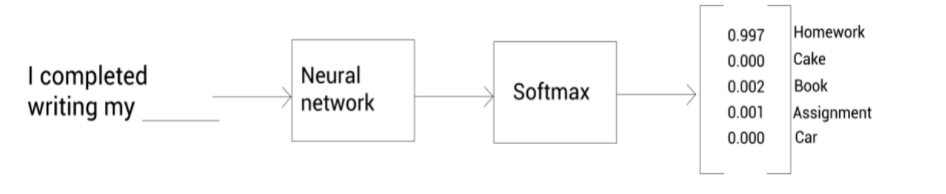

A partir de la figure précédente, nous pouvons remarquer que notre modèle a renvoyé une probabilité très élevée pour le mot homework et une probabilité proche de 0 pour tous les autres mots. Nous pouvons observer que nous n'avons pas beaucoup d'informations dans la distribution de probabilité en dehors de la vérité terrain (le mot correct). Alors, comment pouvons-nous extraire des connaissances obscures ici ?

Dans ce cas, nous utilisons la fonction softmax avec une température. Elle est communément appelée température softmax. Nous utilisons la température softmax dans la couche de sortie. Il est utilisé pour lisser la distribution de probabilité. La fonction softmax avec température s'exprime comme suit :

$$P_i=\frac{exp(z_i/T)}{\sum exp(z_j/T)}$$


Dans l'équation précédente,$T$ est la température. Lorsque nous définissons $T=1$ , il s'agit simplement de notre fonction softmax standard. L'augmentation de la valeur de $T$ rend la distribution de probabilité plus douce et donne plus d'informations sur les autres classes.

Par exemple, comme le montre la figure suivante, lorsque $T=1$ , nous avons la même distribution de probabilité renvoyée par notre réseau avec la fonction softmax standard. Lorsque $T=2$ , la distribution de probabilité est lissée, et avec $T=5$, la distribution de probabilité est encore lissée. Ainsi, en augmentant la valeur de $T$ , nous obtenons une distribution de probabilité lissée, qui donne plus d'informations sur les autres classes :

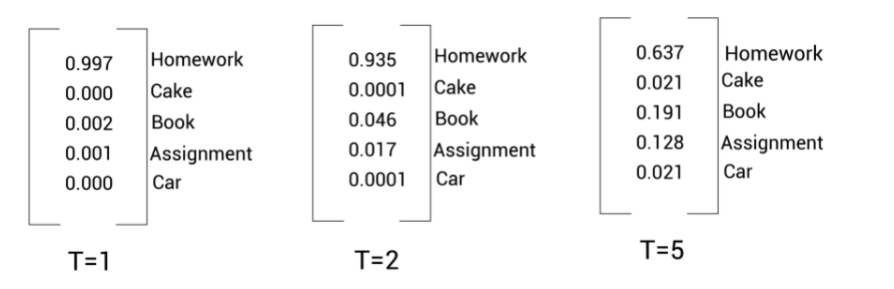

Ainsi, avec la température softmax, nous pouvons obtenir la connaissance sombre. Tout d'abord, nous préformons le réseau d'enseignants avec la température softmax pour obtenir des connaissances sombres. Ensuite, lors de la distillation des connaissances (transfert des connaissances de l'enseignant à l'élève), nous transférons cette connaissance obscure de l'enseignant à l'élève.

D'accord, mais comment transférons-nous les connaissances obscures de l'enseignant à l'élève ? Comment le réseau étudiant est-il formé et comment acquiert-il les connaissances de l'enseignant ? C'est exactement ce dont nous discutons dans la section suivante.

## Former le réseau étudiant
Dans la section précédente, nous avons examiné un réseau pré-entraîné qui prédit le mot suivant dans une phrase. Ce réseau pré-formé est le réseau des enseignants. Maintenant, apprenons à transférer les connaissances de l'enseignant au réseau d'étudiants. Notez que le réseau étudiant n'est pas pré-formé, seul le réseau enseignant est pré-formé et il est pré-formé avec la température softmax.

Comme le montre la figure suivante, nous transmettons la phrase d'entrée aux réseaux d'enseignants et d'étudiants et obtenons la distribution de probabilité en sortie. Nous avons appris que le réseau d'enseignants est un réseau pré-entraîné, donc la distribution de probabilité renvoyée par le réseau d'enseignants sera notre cible. La sortie du réseau d'enseignants est appelée une cible souple, et la prédiction faite par le réseau d'étudiants est appelée une prédiction douce.

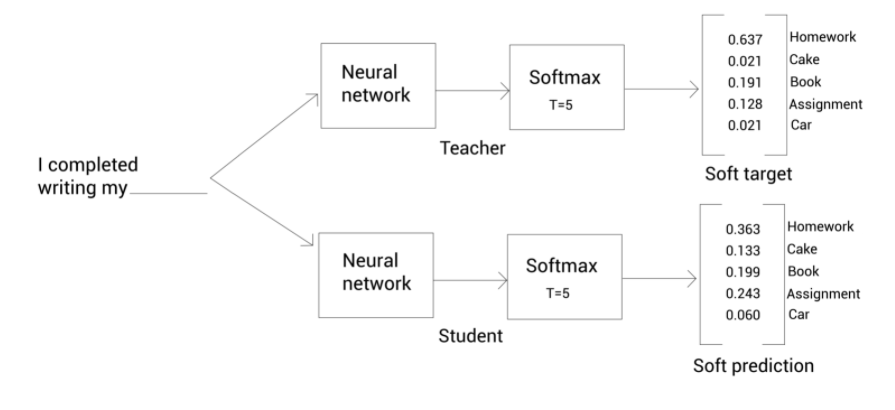

Maintenant, nous calculons la perte d'entropie croisée entre la cible souple et la prédiction douce et formons le réseau étudiant par rétropropagation en minimisant la perte d'entropie croisée. La perte d'entropie croisée entre la cible douce et la prédiction douce est également connue sous le nom de perte de distillation. Nous pouvons également observer à partir de la figure suivante que nous maintenons la température softmax à la même valeur dans le réseau de l'enseignant et de l'élève et qu'elle est définie supérieure à 1 :

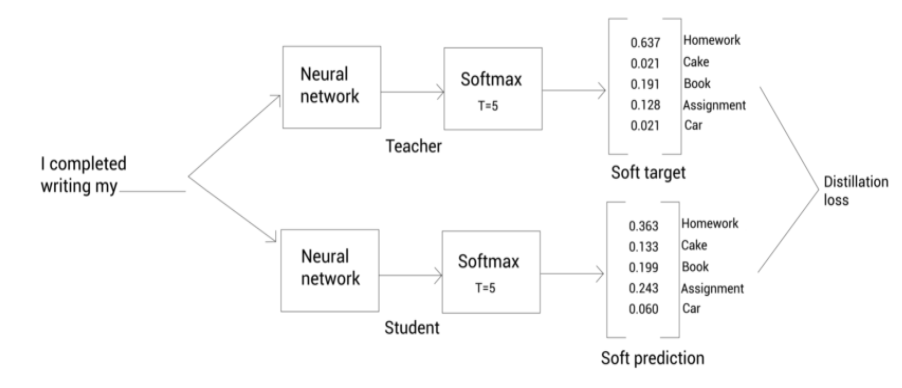

Ainsi, nous formons le réseau étudiant en minimisant les pertes de distillation par rétropropagation. Outre la perte de distillation, nous utilisons également une perte supplémentaire, appelée perte d'étudiant.

Pour comprendre la perte des élèves, comprenons la différence entre la cible molle et la cible dure. Comme le montre la figure suivante, prendre directement la distribution de probabilité renvoyée par le réseau d'enseignants s'appelle la cible souple, alors qu'avec la cible dure, nous définissons simplement 1 là où nous avons une probabilité élevée et nous définissons 0 pour le reste des valeurs :

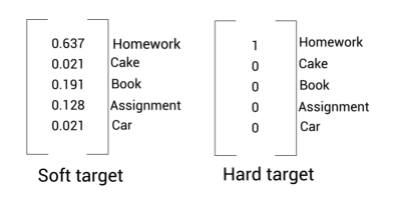

Maintenant, comprenons la différence entre la prédiction douce et la prédiction dure. La prédiction souple est la distribution de probabilité prédite par le réseau étudiant où la température est supérieure à 1, tandis que la prédiction dure est la distribution de probabilité prédite par le réseau étudiant avec la température $T=1$ . C'est-à-dire que la prédiction dure est une prédiction de fonction softmax standard puisque T est défini sur 1.

La perte d'étudiant est essentiellement la perte d'entropie croisée entre la cible dure et la prédiction dure. La figure suivante nous aide à comprendre comment nous calculons exactement la perte d'étudiant et la perte de distillation. Tout d'abord, examinons la perte d'étudiants. Comme nous pouvons l'observer à partir de la figure suivante, pour calculer la perte d'étudiant, nous utilisons la fonction softmax avec dans l'étudiant et obtenons la prédiction dure. Nous obtenons la cible dure en définissant 1 où nous avons une forte probabilité dans la cible douce et 0 dans toutes les autres positions. Ensuite, nous calculons la perte d'étudiant comme l'entropie croisée entre la prédiction dure et la cible dure.

Pour calculer la perte de distillation, nous utilisons la fonction softmax avec un ensemble supérieur à 1 et nous calculons la perte de distillation comme la perte d'entropie croisée entre la prédiction douce et la cible douce :

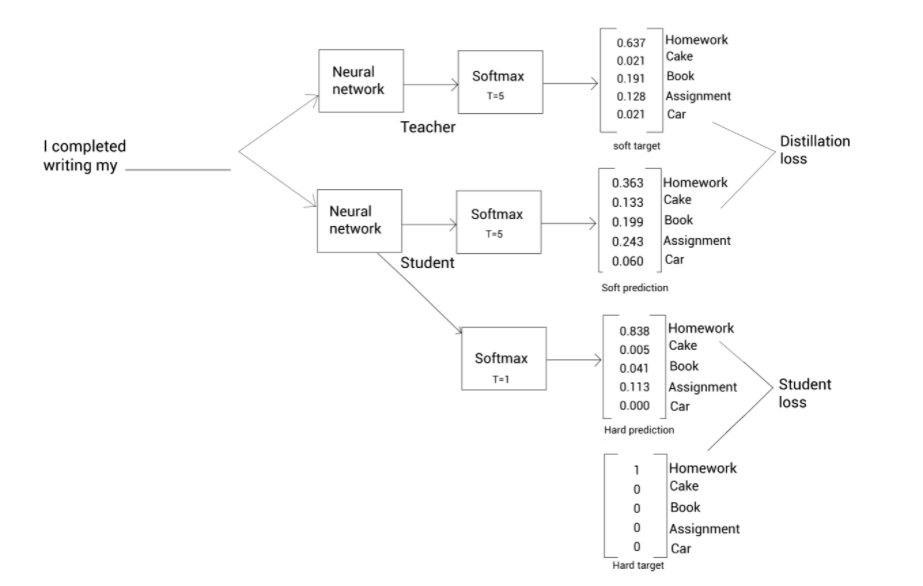

Notre fonction de perte finale est la somme pondérée de la perte d'étudiant et de la perte de distillation et s'exprime comme suit :

$$L=α. student\ loss + β.distillation\ loss $$

$α$ et $β$ sont les hyperparamètres utilisés pour calculer la moyenne pondérée des pertes de Student et de distillation. Nous formons notre réseau d'étudiants en minimisant la fonction de perte ci-dessus.

Ainsi, dans la distillation des connaissances, nous prenons le réseau pré-formé comme réseau d'enseignants. Nous formons le réseau d'étudiants pour obtenir les connaissances du réseau d'enseignants par distillation. Nous formons le réseau d'étudiants en minimisant la perte, qui est la somme pondérée des pertes d'étudiant et de distillation.

Maintenant que nous avons appris ce qu'est la distillation des connaissances et comment elle fonctionne, dans la section suivante, nous apprendrons comment appliquer la distillation des connaissances dans BERT